<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 5: ASHRAE - Great Energy Predictor III (Part 2 Cleaning and Transformation)

 - [Data Cleaning](#Data-Cleaning)

## Data Cleaning

Weather conditions have a significant impact on energy consumption. There is a lot of missing weather data in this weather dataset. This kernel is focused to resolving the problem. We'll also do some feature engineering and transformation on the existing datasets 

#### Importing Libraries

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy
import boto3

from matplotlib.pyplot import figure
from meteocalc import Temp, dew_point, heat_index, wind_chill, feels_like
from numpy import sqrt 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install meteocalc
# !pip install boto3
# !pip install smart_open
# !pip install s3fs
# !pip install boto3

In [2]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = '', #hidden due to privacy issue
    aws_secret_access_key = '' #hidden due to privacy issue 
    
)

In [3]:
import os
os.environ["AWS_DEFAULT_REGION"] = 'us-east-1'
os.environ['AWS_ACCESS_KEY_ID'] = '' #hidden due to privacy issue 
os.environ['AWS_SECRET_ACCESS_KEY'] = '' #hidden due to privacy issue 

In [4]:
obj = s3.Bucket('jiashengs3').Object('EDA_train_df.csv').get()
obj1 = s3.Bucket('jiashengs3').Object('EDA_test_df.csv').get()
obj2 = s3.Bucket('jiashengs3').Object('weather_train.csv').get()
obj3 = s3.Bucket('jiashengs3').Object('weather_test.csv').get()

In [5]:
# retriving cleaned train and test datasets from s3 bucket
train_df = pd.read_csv(obj['Body'],index_col=0, parse_dates=['timestamp'])
test_df = pd.read_csv(obj1['Body'],index_col=0, parse_dates=['timestamp'])
weather_train_df = pd.read_csv(obj2['Body'],index_col=0, parse_dates=['timestamp'])
weather_test_df = pd.read_csv(obj3['Body'],index_col=0, parse_dates=['timestamp'])

In [10]:
# train_df = pd.read_csv('../datasets/raw/final_train_df.csv', parse_dates=['timestamp'])
# test_df = pd.read_csv('../datasets/raw/final_test_df.csv', parse_dates=['timestamp'])
# weather_train_df = pd.read_csv('../datasets/raw/weather_train.csv', parse_dates=['timestamp'])
# weather_test_df = pd.read_csv('../datasets/raw/weather_test.csv', parse_dates=['timestamp'])

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 3238.97 MB
Memory usage after optimization is: 867.58 MB
Decreased by 73.2%


#### Finding bad rows in the train dataset and drop them

Rows are considered bad if they fulfill the following criteria:
- Electric meter with continuous streak of zero readings (24 hours), unlikely to have buildings with 0% electrical usage.
- Heat / Chilled Meters lasting more than 48 hours that typically does not occur within the expected seasons for that meter type
- Site 0 long streak of 0 meter readings
- Outliers building 1099 & 778 as previously discovered in our EDA process 

Function 1: Identify electric meter with continuous streak of zero readings for more than 24 hours

In [50]:
train_df = train_df.reset_index()

In [51]:
#identify all electric meters
masked_df = train_df[(train_df['meter']==0)]

In [52]:
#reset index
masked_df = masked_df.reset_index(drop=True)

In [53]:
masked_df.head()

,index,timestamp,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,...,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,week,day,hour
0,0,2016-01-01,0,0,0.0,0,Education,7432,2008.0,NaN,...,20.0,NaN,1019.5,0.0,0.0,2016,1,53,1,0
1,1,2016-01-01,1,0,0.0,0,Education,2720,2004.0,NaN,...,20.0,NaN,1019.5,0.0,0.0,2016,1,53,1,0
2,2,2016-01-01,2,0,0.0,0,Education,5376,1991.0,NaN,...,20.0,NaN,1019.5,0.0,0.0,2016,1,53,1,0
3,3,2016-01-01,3,0,0.0,0,Education,23685,2002.0,NaN,...,20.0,NaN,1019.5,0.0,0.0,2016,1,53,1,0
4,4,2016-01-01,4,0,0.0,0,Education,116607,1975.0,NaN,...,20.0,NaN,1019.5,0.0,0.0,2016,1,53,1,0


In [54]:
#create feature to sum up the energy consumption for 24 continuous hours
masked_grouped_df = pd.DataFrame(masked_df.groupby(['building_id'])['meter_reading'].rolling(24, min_periods=1).sum()).rename(columns={'meter_reading':'cum_24hrs_meter_reading'})

In [56]:
#identify all meter readings with long streaks of 0 readings
bad_electric_meters = masked_grouped_df[masked_grouped_df['cum_24hrs_meter_reading'] == 0].reset_index()['level_1'].values.tolist()

In [57]:
#drop all bad elect meters observations
masked_df = masked_df[~masked_df.index.isin(bad_electric_meters)]

From our previous eda it is obvious that none of the 16 sites are located in tropical region and experieced the 4 seasons. Below functions will detect abnormal usage of respective meters during summer/winter

Function 2: Identify Heat meters [2/3] with continuous streak of zero readings during winter period
- Winter Ended on Sunday, 20 March 2016 
- Commence again on 21 December 2016 -> 48 hours before 19 Dec 2016 (limit)

In [146]:
#identify all heat and steam meters
masked_df_heaters = train_df[(train_df['meter']==2) | (train_df['meter']==3)]

In [147]:
#reset index
masked_df_heaters = masked_df_heaters.reset_index(drop=True).drop(columns='index')

In [148]:
#isolate seasons outside of winter seasons
untouch_df_heaters = masked_df_heaters[(masked_df_heaters.timestamp > '2016-03-20') & (masked_df_heaters.timestamp < '2016-12-19')]

In [149]:
#identify winter period
winter_df_heaters = masked_df_heaters[(masked_df_heaters.timestamp <= '2016-03-20') | (masked_df_heaters.timestamp >= '2016-12-19')]

In [150]:
#reset index
winter_df_heaters = winter_df_heaters.reset_index(drop=True)

In [151]:
#create feature to sum up the energy consumption for 48 continuous hours
masked_df_grouped_heaters = pd.DataFrame(winter_df_heaters.groupby(['building_id'])['meter_reading'].rolling(48, min_periods=1).sum()).rename(columns={'meter_reading':'cum_48hrs_meter_reading'})

In [152]:
#identify all meter readings with long streaks of 0 readings during winter times
bad_heater_meters = masked_df_grouped_heaters[(masked_df_grouped_heaters['cum_48hrs_meter_reading'] == 0) ].reset_index()['level_1'].values.tolist()

In [153]:
#drop all bad heat meters observations
winter_df_heaters = winter_df_heaters[~winter_df_heaters.index.isin(bad_heater_meters)]

In [154]:
good_meters_2_3 = pd.concat([winter_df_heaters,untouch_df_heaters],axis=0).reset_index(drop=True)

In [155]:
good_meters_2_3.shape

(3935637, 21)

Function 3: Identify chilled meters [1] with continuous streak of zero readings during summer period
- Summer Ended on Sunday, 22 Sept 2016 
- Commence on 21 June 2016 -> 48 hours before 19 June 2016 (limit)

In [173]:
#identify all heat and steam meters
masked_df_cooler = train_df[train_df['meter']==1]

In [174]:
#reset index
masked_df_cooler = masked_df_cooler.reset_index(drop=True).drop(columns='index')

In [175]:
#isolate seasons outside summer period
untouch_df_cooler = masked_df_cooler[(masked_df_cooler.timestamp > '2016-09-22') | (masked_df_cooler.timestamp < '2016-06-19')]

In [176]:
#identify summer period
summer_df_cooler = masked_df_cooler[(masked_df_cooler.timestamp <= '2016-09-22') & (masked_df_cooler.timestamp >= '2016-06-19')]

In [178]:
#reset index
summer_df_cooler = summer_df_cooler.reset_index(drop=True)

In [180]:
#create feature to sum up the energy consumption for 48 continuous hours
masked_df_grouped_cooler = pd.DataFrame(summer_df_cooler.groupby(['building_id'])['meter_reading'].rolling(48, min_periods=1).sum()).rename(columns={'meter_reading':'cum_48hrs_meter_reading'})

In [181]:
#identify all meter readings with long streaks of 0 readings during winter times
bad_cooler_meters = masked_df_grouped_cooler[(masked_df_grouped_cooler['cum_48hrs_meter_reading'] == 0) ].reset_index()['level_1'].values.tolist()

In [191]:
#drop all bad chilled meters observations
summer_df_cooler = summer_df_cooler[~summer_df_cooler.index.isin(bad_cooler_meters)]

In [193]:
good_meters_1 = pd.concat([summer_df_cooler,untouch_df_cooler],axis=0).reset_index(drop=True)

In [281]:
#Combined all 3 dataframes, 510,240 dropped
pdList = [masked_df, good_meters_2_3, good_meters_1]
cleaned_train_df = pd.concat(pdList)

In [282]:
cleaned_train_df = cleaned_train_df.sort_values(by='timestamp').reset_index(drop=True).drop(columns='index')

Previously from Part 1 EDA, we observed from January to March 2016, most of the facilities in site 0 had no consumption readings, indicating that the site was newly erected and under development at the time.

Function 4: Identify observations with abnormal meter readings at Site 0 before march 2016

Text(0, 0.5, 'meter_reading')

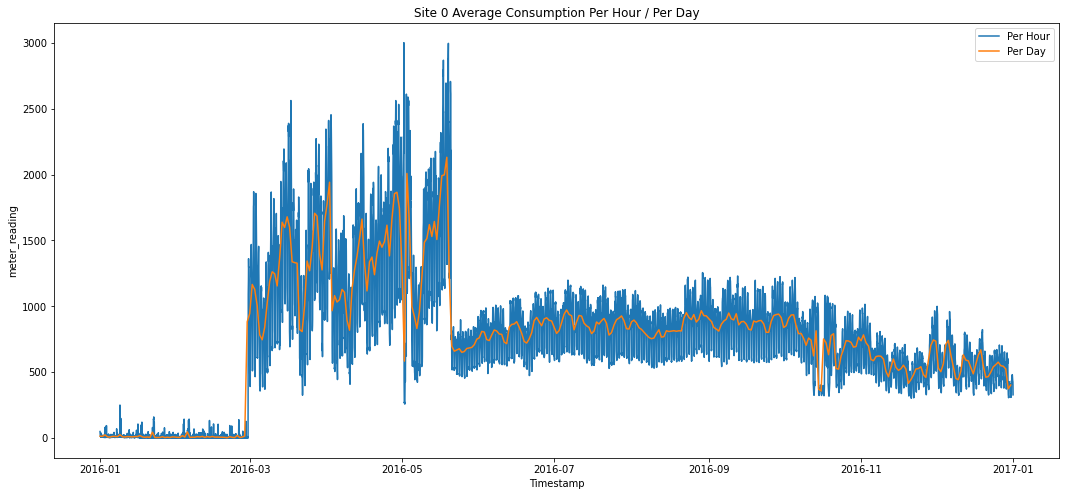

In [283]:
plt.figure(figsize=(18,8))
sns.lineplot(x = 'timestamp',y = 'meter_reading', palette= 'Spectral', data=cleaned_train_df[cleaned_train_df['site_id'] == 0][['timestamp', 'meter_reading']].set_index('timestamp').resample('h').mean().reset_index(), ci = None, label = "Per Hour")
sns.lineplot(x = 'timestamp',y = 'meter_reading', palette= 'Spectral', data=cleaned_train_df[cleaned_train_df['site_id'] == 0][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean().reset_index(), ci = None, label = "Per Day")
plt.title(f'Site 0 Average Consumption Per Hour / Per Day')
plt.xlabel('Timestamp')
plt.ylabel(f'meter_reading')

In [284]:
cleaned_train_df.groupby('site_id')['meter_reading'].describe()

,count,mean,std,min,25%,50%,75%,max
site_id,,,,,,,,
0,758098.0,780.920532,1440.979858,0.0,97.060097,266.608002,667.817017,1.726110e+05
1,553210.0,149.571152,185.463562,0.0,30.000000,78.241447,200.699997,2.270000e+04
2,2506242.0,185.553009,346.212158,0.0,18.170000,77.194901,193.979996,6.895630e+03
3,2369379.0,125.957458,259.781708,0.0,18.520000,46.680000,110.120003,3.095440e+03
4,746457.0,181.157898,285.329895,0.0,18.000000,70.500000,201.973999,2.293880e+03
5,778405.0,31.434389,62.198074,0.0,3.800000,10.880000,31.299999,9.541000e+02
6,660461.0,1002.342712,19097.062500,0.0,18.556000,84.366699,277.272003,8.803740e+05
7,354339.0,1259.823853,1695.250977,0.0,16.245000,567.020020,1850.135010,1.750210e+04
8,548442.0,68.071907,220.721619,0.0,3.375000,15.000000,38.974602,4.373170e+03


In [285]:
site_0_df = cleaned_train_df[(cleaned_train_df['site_id']==0) & (cleaned_train_df['timestamp']<'2016-03-01') & (cleaned_train_df['meter_reading']<50)]

In [286]:
bad_site0 = site_0_df.index.values.tolist()

In [287]:
#drop all bad meters observations at site 0
cleaned_train_df = cleaned_train_df[~cleaned_train_df.index.isin(bad_site0)]

Function 5: Dropped observations with extremely high meter readings for outlier building 1099 (meter2) and 778 (meter1)

In [288]:
outlier_building1099 = cleaned_train_df[(cleaned_train_df['building_id'] == 1099) & (cleaned_train_df['meter'] == 2)]

In [289]:
outlier_building1099.meter_reading.describe()

count        8784.00
mean      3813882.25
std       6282403.00
min           144.00
25%          1608.00
50%          7008.00
75%       6340610.00
max      21904700.00
Name: meter_reading, dtype: float64

In [290]:
#identify consumption above 75% quartile in building 1099
outlier_1099 = outlier_building1099[outlier_building1099['meter_reading'] > 6340610.00].index.to_list()

In [291]:
outlier_building788 = cleaned_train_df[(cleaned_train_df['building_id'] == 778) & (cleaned_train_df['meter'] == 1)]

In [295]:
outlier_building788[outlier_building788['meter_reading']>0].meter_reading.describe()

count       843.000000
mean     519913.593750
std      125272.789062
min           0.586100
25%      440245.500000
50%      519865.000000
75%      594733.500000
max      880374.000000
Name: meter_reading, dtype: float64

In [296]:
#identify consumption above 75% quartile in building 788
outlier_788 = outlier_building788[outlier_building788['meter_reading'] > 594733].index.to_list()

In [299]:
#drop all bad meters observations at building 1099 and 788
cleaned_train_df = cleaned_train_df[(~cleaned_train_df.index.isin(outlier_1099)) & (~cleaned_train_df.index.isin(outlier_788))]

In [300]:
cleaned_train_df.shape

(19689551, 21)

#### Recap NaN from Part 1(EDA)

In [301]:
def check_null_percentrage(df):
    for col in df.columns:
        n_nan = df[col].isnull().sum()
        if n_nan > 0:
            print(f"{col} has {n_nan} NaNs, this represents {round(n_nan/len(df)*100,2)}% of the data")
    return

In [302]:
dataset = [(weather_train_df,'weather_train_df'),(weather_test_df,'weather_test_df')]

In [303]:
for dataset,name in dataset:
    
    print(name)
    check_null_percentrage(dataset)
    print('---------------------------------------------------------')

weather_train_df
air_temperature has 55 NaNs, this represents 0.04% of the data
cloud_coverage has 69173 NaNs, this represents 49.49% of the data
dew_temperature has 113 NaNs, this represents 0.08% of the data
precip_depth_1_hr has 50289 NaNs, this represents 35.98% of the data
sea_level_pressure has 10618 NaNs, this represents 7.6% of the data
wind_direction has 6268 NaNs, this represents 4.48% of the data
wind_speed has 304 NaNs, this represents 0.22% of the data
---------------------------------------------------------
weather_test_df
air_temperature has 104 NaNs, this represents 0.04% of the data
cloud_coverage has 140448 NaNs, this represents 50.66% of the data
dew_temperature has 327 NaNs, this represents 0.12% of the data
precip_depth_1_hr has 95588 NaNs, this represents 34.48% of the data
sea_level_pressure has 21265 NaNs, this represents 7.67% of the data
wind_direction has 12370 NaNs, this represents 4.46% of the data
wind_speed has 460 NaNs, this represents 0.17% of the data

#### From Part 1, we found missing time gaps in our weather datasets, we will fix that now.

In [304]:
print('weather_train_df')
print(weather_train_df.shape)
print('weather_test_df')
print(weather_test_df.shape)

weather_train_df
(139773, 8)
weather_test_df
(277243, 8)


In [305]:
weather_train_df.isnull().sum()

timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [306]:
weather_test_df.isnull().sum()

timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
dtype: int64

In [307]:
weather_train_df = weather_train_df.reset_index()
weather_test_df = weather_test_df.reset_index()

In [308]:
#weather train dataset
new_date_range = pd.date_range(start = '2016-01-01 00:00:00', end = '2016-12-31 23:00:00', freq = 'H')
weather_train_df = weather_train_df.set_index('timestamp')
weather_train_df = weather_train_df.groupby('site_id').apply(lambda x : x.reindex(new_date_range)).rename(columns={'site_id':'site_id2'}).reset_index(drop=False)   #

In [309]:
#after filling in all the missing time series in all 16 sites
weather_train_df.shape

(140544, 10)

In [310]:
weather_train_df.rename({'level_1':'timestamp'},axis=1, inplace=True)
weather_train_df.drop(columns='site_id2', inplace=True)

In [311]:
#to confirm all 16 sites have no more missing time series
for site in range(16):    
    missing = pd.date_range(start = '2016-01-01 00:00:00', end = '2016-12-31 23:00:00', freq = 'H').difference(weather_train_df[weather_train_df['site_id']==site].timestamp)
    print(site, missing)

0 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
1 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
2 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
3 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
4 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
5 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
6 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
7 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
8 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
9 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
10 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
11 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
12 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
13 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
14 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
15 DatetimeIndex([], dtype='datetime64[ns]', freq='H')


In [312]:
weather_train_df.isnull().sum()

site_id                   0
timestamp                 0
air_temperature         826
cloud_coverage        69944
dew_temperature         884
precip_depth_1_hr     51060
sea_level_pressure    11389
wind_direction         7039
wind_speed             1075
dtype: int64

In [313]:
#weather test dataset
new_date_range = pd.date_range(start = '2017-01-01 00:00:00', end = '2018-12-31 23:00:00', freq = 'H')
weather_test_df = weather_test_df.set_index('timestamp')
weather_test_df = weather_test_df.groupby('site_id').apply(lambda x : x.reindex(new_date_range)).rename(columns={'site_id':'site_id2'}).reset_index(drop=False)

In [314]:
#after filling in all the missing time series in all 16 sites
weather_test_df.shape

(280320, 10)

In [315]:
weather_test_df.rename({'level_1':'timestamp'},axis=1, inplace=True)
weather_test_df.drop(columns='site_id2', inplace=True)

In [316]:
#to confirm all 16 sites have no more missing time series
for site in range(16):    
    missing = pd.date_range(start = '2017-01-01 00:00:00', end = '2018-12-31 23:00:00', freq = 'H').difference(weather_test_df[weather_test_df['site_id']==site].timestamp)
    print(site, missing)

0 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
1 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
2 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
3 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
4 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
5 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
6 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
7 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
8 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
9 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
10 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
11 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
12 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
13 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
14 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
15 DatetimeIndex([], dtype='datetime64[ns]', freq='H')


In [317]:
weather_test_df.isnull().sum()

site_id                    0
timestamp                  0
air_temperature         3181
cloud_coverage        143525
dew_temperature         3404
precip_depth_1_hr      98665
sea_level_pressure     24342
wind_direction         15447
wind_speed              3537
dtype: int64

#### Filling in missing values for weather parameters

Since we know different sites experience different weather readings, we will attempt to impute the nan values with the ffill and bfill value based on each site, month and day. For the remaining nan values, we will fill them with the median value of that column>

In [318]:
#temporal features for our train weather data
weather_train_df['year'] = weather_train_df['timestamp'].dt.year
weather_train_df['month'] = weather_train_df['timestamp'].dt.month
weather_train_df['week'] = weather_train_df['timestamp'].dt.isocalendar().week
weather_train_df['day'] = weather_train_df['timestamp'].dt.day
weather_train_df['hour'] = weather_train_df['timestamp'].dt.hour

In [319]:
#temporal features for our test weather data
weather_test_df['year'] = weather_test_df['timestamp'].dt.year
weather_test_df['month'] = weather_test_df['timestamp'].dt.month
weather_test_df['week'] = weather_test_df['timestamp'].dt.isocalendar().week
weather_test_df['day'] = weather_test_df['timestamp'].dt.day
weather_test_df['hour'] = weather_test_df['timestamp'].dt.hour

In [320]:
weather_train_df_copy = weather_train_df
weather_test_df_copy = weather_test_df

In [321]:
weather_ls = ['air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed']

#### Imputing Train Weather Dataset

In [322]:
#impute nan using pandas ffill and bfill methods after groupby site_id, month and day
for weather_param in weather_ls:
    print(f"Before imputation: Number of NaNs for {weather_param}-> {weather_train_df_copy[weather_param].isnull().sum()}")
    weather_train_df_copy[f"{weather_param}_1"] = weather_train_df_copy.groupby(['site_id', 'month', 'day'])[weather_param].transform(lambda x: x.ffill())
    print(f"After forward imputation: Number of NaNs-> {weather_train_df_copy[f'{weather_param}_1'].isnull().sum()}")
    weather_train_df_copy[f"{weather_param}_1"] = weather_train_df_copy.groupby(['site_id', 'month', 'day'])[f"{weather_param}_1"].transform(lambda x: x.bfill())
    print(f"After backward imputation: Number of NaNs-> {weather_train_df_copy[f'{weather_param}_1'].isnull().sum()}")
    print(f"Data impututation for {weather_param} is done")
    print("-----------------------------------------------------------------------------------")

weather_train_df_copy.drop(columns=['air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], inplace=True)

Before imputation: Number of NaNs for air_temperature-> 826
After forward imputation: Number of NaNs-> 120
After backward imputation: Number of NaNs-> 0
Data impututation for air_temperature is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for cloud_coverage-> 69944
After forward imputation: Number of NaNs-> 33477
After backward imputation: Number of NaNs-> 25800
Data impututation for cloud_coverage is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for dew_temperature-> 884
After forward imputation: Number of NaNs-> 121
After backward imputation: Number of NaNs-> 0
Data impututation for dew_temperature is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for precip_depth_1_hr-> 51060
After forward imputation: Number of NaNs-> 45144
After backward imputation: Numbe

In [323]:
updated_weather_ls = ['cloud_coverage_1','precip_depth_1_hr_1', 'sea_level_pressure_1']

In [324]:
#impute remaining nan with mean values of column after groupby site_id, week
for weather_param in updated_weather_ls:
    print(f"Before imputation: Number of NaNs for {weather_param}-> {weather_train_df_copy[weather_param].isnull().sum()}")
    weather_train_df_copy[weather_param] = weather_train_df_copy.groupby(['site_id','week'])[weather_param].transform(lambda x: x.fillna(x.mean()))
    print(f"After imputation: Number of NaNs-> {weather_train_df_copy[f'{weather_param}'].isnull().sum()}")
    print(f"Data impututation for {weather_param} is done")
    print("-----------------------------------------------------------------------------------")

Before imputation: Number of NaNs for cloud_coverage_1-> 25800
After imputation: Number of NaNs-> 17568
Data impututation for cloud_coverage_1 is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for precip_depth_1_hr_1-> 41016
After imputation: Number of NaNs-> 28608
Data impututation for precip_depth_1_hr_1 is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for sea_level_pressure_1-> 9000
After imputation: Number of NaNs-> 8856
Data impututation for sea_level_pressure_1 is done
-----------------------------------------------------------------------------------


In [325]:
#impute remaining nan with mean values of column after groupby site_id, month
for weather_param in updated_weather_ls:
    print(f"Before imputation: Number of NaNs for {weather_param}-> {weather_train_df_copy[weather_param].isnull().sum()}")
    weather_train_df_copy[weather_param] = weather_train_df_copy.groupby(['site_id','month'])[weather_param].transform(lambda x: x.fillna(x.mean()))
    print(f"After imputation: Number of NaNs-> {weather_train_df_copy[f'{weather_param}'].isnull().sum()}")
    print(f"Data impututation for {weather_param} is done")
    print("-----------------------------------------------------------------------------------")

Before imputation: Number of NaNs for cloud_coverage_1-> 17568
After imputation: Number of NaNs-> 17568
Data impututation for cloud_coverage_1 is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for precip_depth_1_hr_1-> 28608
After imputation: Number of NaNs-> 26352
Data impututation for precip_depth_1_hr_1 is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for sea_level_pressure_1-> 8856
After imputation: Number of NaNs-> 8784
Data impututation for sea_level_pressure_1 is done
-----------------------------------------------------------------------------------


In [326]:
#impute remaining nan with mean valye of each column
for weather_param in updated_weather_ls:
    
    print(f"Before imputation: Number of NaNs for {weather_param}-> {weather_train_df_copy[weather_param].isnull().sum()}")
    weather_train_df_copy[weather_param].fillna(weather_train_df_copy[weather_param].mean(), inplace=True)
    print(f"After imputation: Number of NaNs-> {weather_train_df_copy[f'{weather_param}'].isnull().sum()}")
    print(f"Data impututation for {weather_param} is done")
    print("-----------------------------------------------------------------------------------")

Before imputation: Number of NaNs for cloud_coverage_1-> 17568
After imputation: Number of NaNs-> 0
Data impututation for cloud_coverage_1 is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for precip_depth_1_hr_1-> 26352
After imputation: Number of NaNs-> 0
Data impututation for precip_depth_1_hr_1 is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for sea_level_pressure_1-> 8784
After imputation: Number of NaNs-> 0
Data impututation for sea_level_pressure_1 is done
-----------------------------------------------------------------------------------


#### Imputing Test Weather Dataset

In [327]:
#impute nan using pandas ffill and bfill methods after groupby site_id, month and day
for weather_param in weather_ls:
    print(f"Before imputation: Number of NaNs for {weather_param}-> {weather_test_df_copy[weather_param].isnull().sum()}")
    weather_test_df_copy[f"{weather_param}_1"] = weather_test_df_copy.groupby(['site_id', 'month', 'day'])[weather_param].transform(lambda x: x.ffill())
    print(f"After forward imputation: Number of NaNs-> {weather_test_df_copy[f'{weather_param}_1'].isnull().sum()}")
    weather_test_df_copy[f"{weather_param}_1"] = weather_test_df_copy.groupby(['site_id', 'month', 'day'])[f"{weather_param}_1"].transform(lambda x: x.bfill())
    print(f"After backward imputation: Number of NaNs-> {weather_test_df_copy[f'{weather_param}_1'].isnull().sum()}")
    print(f"Data impututation for {weather_param} is done")
    print("-----------------------------------------------------------------------------------")

weather_test_df_copy.drop(columns=['air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], inplace=True)

Before imputation: Number of NaNs for air_temperature-> 3181
After forward imputation: Number of NaNs-> 680
After backward imputation: Number of NaNs-> 0
Data impututation for air_temperature is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for cloud_coverage-> 143525
After forward imputation: Number of NaNs-> 54250
After backward imputation: Number of NaNs-> 38928
Data impututation for cloud_coverage is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for dew_temperature-> 3404
After forward imputation: Number of NaNs-> 696
After backward imputation: Number of NaNs-> 0
Data impututation for dew_temperature is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for precip_depth_1_hr-> 98665
After forward imputation: Number of NaNs-> 78196
After backward imputation: Nu

In [328]:
#impute remaining nan with mean values of column after groupby site_id, week
for weather_param in updated_weather_ls:
    print(f"Before imputation: Number of NaNs for {weather_param}-> {weather_test_df_copy[weather_param].isnull().sum()}")
    weather_test_df_copy[weather_param] = weather_test_df_copy.groupby(['site_id','week'])[weather_param].transform(lambda x: x.fillna(x.mean()))
    print(f"After imputation: Number of NaNs-> {weather_test_df_copy[f'{weather_param}'].isnull().sum()}")
    print(f"Data impututation for {weather_param} is done")
    print("-----------------------------------------------------------------------------------")

Before imputation: Number of NaNs for cloud_coverage_1-> 38928
After imputation: Number of NaNs-> 35040
Data impututation for cloud_coverage_1 is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for precip_depth_1_hr_1-> 65808
After imputation: Number of NaNs-> 52560
Data impututation for precip_depth_1_hr_1 is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for sea_level_pressure_1-> 17520
After imputation: Number of NaNs-> 17520
Data impututation for sea_level_pressure_1 is done
-----------------------------------------------------------------------------------


In [329]:
#impute remaining nan with mean values of column after groupby site_id, month
for weather_param in updated_weather_ls:
    print(f"Before imputation: Number of NaNs for {weather_param}-> {weather_test_df_copy[weather_param].isnull().sum()}")
    weather_test_df_copy[weather_param] = weather_test_df_copy.groupby(['site_id','month'])[weather_param].transform(lambda x: x.fillna(x.mean()))
    print(f"After imputation: Number of NaNs-> {weather_test_df_copy[f'{weather_param}'].isnull().sum()}")
    print(f"Data impututation for {weather_param} is done")
    print("-----------------------------------------------------------------------------------")

Before imputation: Number of NaNs for cloud_coverage_1-> 35040
After imputation: Number of NaNs-> 35040
Data impututation for cloud_coverage_1 is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for precip_depth_1_hr_1-> 52560
After imputation: Number of NaNs-> 52560
Data impututation for precip_depth_1_hr_1 is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for sea_level_pressure_1-> 17520
After imputation: Number of NaNs-> 17520
Data impututation for sea_level_pressure_1 is done
-----------------------------------------------------------------------------------


In [330]:
#impute remaining nan with mean valye of each column
for weather_param in updated_weather_ls:
    
    print(f"Before imputation: Number of NaNs for {weather_param}-> {weather_test_df_copy[weather_param].isnull().sum()}")
    weather_test_df_copy[weather_param].fillna(weather_test_df_copy[weather_param].mean(), inplace=True)
    print(f"After imputation: Number of NaNs-> {weather_test_df_copy[f'{weather_param}'].isnull().sum()}")
    print(f"Data impututation for {weather_param} is done")
    print("-----------------------------------------------------------------------------------")

Before imputation: Number of NaNs for cloud_coverage_1-> 35040
After imputation: Number of NaNs-> 0
Data impututation for cloud_coverage_1 is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for precip_depth_1_hr_1-> 52560
After imputation: Number of NaNs-> 0
Data impututation for precip_depth_1_hr_1 is done
-----------------------------------------------------------------------------------
Before imputation: Number of NaNs for sea_level_pressure_1-> 17520
After imputation: Number of NaNs-> 0
Data impututation for sea_level_pressure_1 is done
-----------------------------------------------------------------------------------


#### Feature Engineering Part 1 (Relative humidity, Seasons, Public Holidays, Lag Features)

Formula to describe relation between dew point, air temperature, and relative humidity: https://www.omnicalculator.com/physics/relative-humidity



In [331]:
#feature engineer R.H
weather_train_df_copy['RH%'] = 100*(np.exp((17.67 * (weather_train_df_copy['dew_temperature_1'])) / (243.5 + (weather_train_df_copy['dew_temperature_1']))))/(np.exp((17.67 * (weather_train_df_copy['air_temperature_1'])) / (243.5 + (weather_train_df_copy['air_temperature_1']))))

In [332]:
weather_test_df_copy['RH%'] = 100*(np.exp((17.67 * (weather_test_df_copy['dew_temperature_1'])) / (243.5 + (weather_test_df_copy['dew_temperature_1']))))/(np.exp((17.67 * (weather_test_df_copy['air_temperature_1'])) / (243.5 + (weather_test_df_copy['air_temperature_1']))))

Seasons will affect energy consumption; heaters will be used more frequently in the winter and air conditioners will be used more frequently in the summer.

In [333]:
#feature engineer seasons in train dataset
weather_train_df_copy['season']= weather_train_df_copy['month'].apply(lambda x: 'Spring' if x in [3,4,5] else 'Summer' if 
                                                x in [6,7,8] 
                                                else 'Autumn' if x in [9,10,11] else 'Winter')

In [334]:
#feature engineer seasons in test dataset
weather_test_df_copy['season']= weather_test_df_copy['month'].apply(lambda x: 'Spring' if x in [3,4,5] else 'Summer' if 
                                                x in [6,7,8] 
                                                else 'Autumn' if x in [9,10,11] else 'Winter')

Other weather parameters from meteocalc library

In [335]:
#windchill formula derived from https://sciencing.com/calculate-wind-chill-factor-5981683.html
def windchill(T,V):#T = deg C, V = mps
    wind_chill = 13.12 + 0.6215 * T - 11.37 * ((V*3.6)**0.16) + 0.3965 * T * ((V*3.6)**0.16) 
    return wind_chill 

In [336]:
#heat, feellike and windchill (derived from raw weather data)
weather_train_df_copy['Heat_index(degC)'] = weather_train_df_copy.apply(lambda x: heat_index((x['air_temperature_1'] * 9 / 5. + 32), x['RH%']).c, axis=1)
weather_train_df_copy['Wind_chill(degC)'] = weather_train_df_copy.apply(lambda x: windchill((x['air_temperature_1']), (x['wind_speed_1'])), axis=1)
weather_train_df_copy['feels_like(degC)'] = weather_train_df_copy.apply(lambda x: feels_like((x['air_temperature_1'] * 9 / 5. + 32), x['RH%'], x['wind_speed_1']).c, axis=1)

In [337]:
#heat, feellike and windchill (derived from raw weather data)
weather_test_df_copy['Heat_index(degC)'] = weather_test_df_copy.apply(lambda x: heat_index((x['air_temperature_1'] * 9 / 5. + 32), x['RH%']).c, axis=1)
weather_test_df_copy['Wind_chill(degC)'] = weather_test_df_copy.apply(lambda x: windchill((x['air_temperature_1']), (x['wind_speed_1'])), axis=1)
weather_test_df_copy['feels_like(degC)'] = weather_test_df_copy.apply(lambda x: feels_like((x['air_temperature_1'] * 9 / 5. + 32), x['RH%'], x['wind_speed_1']).c, axis=1)

Add rolled features for air_temp, dew_temp, heat_idnex, wind_chill, feels_like parameters

In [338]:
#introduce lag features
def add_lag_feature(weather_df, window=3):  
    lagged_cols = ['air_temperature_1', 'dew_temperature_1', 'Heat_index(degC)', 'Wind_chill(degC)', 'feels_like(degC)']
    
    for col in lagged_cols:
        weather_df[f'{col}_mean_lag{window}'] = weather_df.groupby(['site_id']).rolling(window, min_periods=1, on='timestamp')[col].mean().reset_index()[col]

In [339]:
add_lag_feature(weather_train_df_copy)

In [340]:
add_lag_feature(weather_test_df_copy)

#### Merging our cleaned weather dataframes with our trian/test datasets

Removing the temoporal features for our weather train and test datasets

In [341]:
weather_train_df_copy.drop(columns=['year','month','week','day','hour'],inplace=True)
weather_test_df_copy.drop(columns=['year','month','week','day','hour'],inplace=True)

In [342]:
drop_cols = ['air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed']

In [343]:
cleaned_train_df = cleaned_train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

In [344]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [345]:
cleaned_train_df.set_index('timestamp',inplace=True)
weather_train_df_copy.set_index('timestamp',inplace=True)
weather_test_df_copy.set_index('timestamp',inplace=True)

In [346]:
# print('Compressed Train Dataframe')
# cleaned_train_df = reduce_mem_usage(cleaned_train_df)
# print('--------------------------------------------------------------')
print('Compressed Test Dataframe')
test_df = reduce_mem_usage(test_df)
print('--------------------------------------------------------------')
print('Compressed Weather Train Dataframe')
weather_train_df_copy = reduce_mem_usage(weather_train_df_copy)
print('--------------------------------------------------------------')
print('Compressed Weather Test Dataframe')
compressed_weather_test_df = reduce_mem_usage(weather_test_df_copy)
print('--------------------------------------------------------------')

Compressed Test Dataframe
Memory usage of dataframe is 4453.78 MB
Memory usage after optimization is: 1232.74 MB
Decreased by 72.3%
--------------------------------------------------------------
Compressed Weather Train Dataframe
Memory usage of dataframe is 20.37 MB
Memory usage after optimization is: 5.63 MB
Decreased by 72.4%
--------------------------------------------------------------
Compressed Weather Test Dataframe
Memory usage of dataframe is 40.63 MB
Memory usage after optimization is: 11.23 MB
Decreased by 72.4%
--------------------------------------------------------------


In [347]:
final_train_df = cleaned_train_df.merge(weather_train_df_copy, on=['site_id', 'timestamp'], how='left')
final_test_df = test_df.merge(weather_test_df_copy, on=['site_id', 'timestamp'], how='left')

In [348]:
final_train_df.isnull().sum()

building_id                           0
meter                                 0
meter_reading                         0
site_id                               0
primary_use                           0
square_feet                           0
year_built                     11976559
floor_count                    16223838
year                                  0
month                                 0
week                                  0
day                                   0
hour                                  0
air_temperature_1                     0
cloud_coverage_1                      0
dew_temperature_1                     0
precip_depth_1_hr_1                   0
sea_level_pressure_1                  0
wind_direction_1                      0
wind_speed_1                          0
RH%                                   0
season                                0
Heat_index(degC)                      0
Wind_chill(degC)                      0
feels_like(degC)                      0


In [349]:
final_test_df.isnull().sum()

row_id                                0
building_id                           0
meter                                 0
site_id                               0
primary_use                           0
square_feet                           0
year_built                     24598080
floor_count                    34444320
year                                  0
month                                 0
week                                  0
day                                   0
hour                                  0
air_temperature_1                     0
cloud_coverage_1                      0
dew_temperature_1                     0
precip_depth_1_hr_1                   0
sea_level_pressure_1                  0
wind_direction_1                      0
wind_speed_1                          0
RH%                                   0
season                                0
Heat_index(degC)                      0
Wind_chill(degC)                      0
feels_like(degC)                      0


#### Feature Engineering Part 2 (buildings counts per site, buildings counts per primary usage type)

Train Building Dataset

In [350]:
#create a dictionary to store the Building Counts Per Site (bcps)
dict_bcps = final_train_df.groupby('site_id').agg({'building_id':'count'}).to_dict()

In [351]:
dict_bcps_1 = {}
for values in dict_bcps.values():
    for k,v in values.items():
        dict_bcps_1[k] = v

dict_bcps_1

{0: 744196,
 1: 553210,
 2: 2506242,
 3: 2369379,
 4: 746457,
 5: 778405,
 6: 660250,
 7: 354339,
 8: 548442,
 9: 2641421,
 10: 405809,
 11: 119459,
 12: 315509,
 13: 2680956,
 14: 2459382,
 15: 1806095}

In [352]:
final_train_df['bcps']=final_train_df['site_id'].map(dict_bcps_1)

In [354]:
#create a dictionary to store the Building Counts Per Facility (bcpf)
dict_bcpf = final_train_df.groupby('primary_use').agg({'building_id':'count'}).to_dict()

In [355]:
dict_bcpf_1 = {}
for values in dict_bcpf.values():
    for k,v in values.items():
        dict_bcpf_1[k] = v

dict_bcpf_1

{'Education': 7977184,
 'Entertainment/public assembly': 2221062,
 'Food sales and service': 113570,
 'Healthcare': 389877,
 'Lodging/residential': 2051203,
 'Manufacturing/industrial': 125713,
 'Office': 4274265,
 'Other': 226691,
 'Parking': 187924,
 'Public services': 1657016,
 'Religious worship': 32280,
 'Retail': 91770,
 'Services': 95796,
 'Technology/science': 77139,
 'Utility': 56203,
 'Warehouse/storage': 111858}

In [356]:
final_train_df['bcpf']=final_train_df['primary_use'].map(dict_bcpf_1)

Test Building Dataset

In [358]:
#create a dictionary to store the Building Counts Per Site (bcps)
dict_bcps_test = final_test_df.groupby('site_id').agg({'building_id':'count'}).to_dict()

In [359]:
dict_bcps_2 = {}
for values in dict_bcps_test.values():
    for k,v in values.items():
        dict_bcps_2[k] = v

dict_bcps_2

{0: 2260080,
 1: 1103760,
 2: 5063280,
 3: 4800480,
 4: 1594320,
 5: 1559280,
 6: 1401600,
 7: 735840,
 8: 1226400,
 9: 5361120,
 10: 876000,
 11: 245280,
 12: 630720,
 13: 5413680,
 14: 5045760,
 15: 4380000}

In [360]:
final_test_df['bcps']=final_test_df['site_id'].map(dict_bcps_2)

In [362]:
#create a dictionary to store the Building Counts Per Facility (bcpf)
dict_bcpf_test = final_test_df.groupby('primary_use').agg({'building_id':'count'}).to_dict()

In [363]:
dict_bcpf_2 = {}
for values in dict_bcpf_test.values():
    for k,v in values.items():
        dict_bcpf_2[k] = v

dict_bcpf_2

{'Education': 16801680,
 'Entertainment/public assembly': 4712880,
 'Food sales and service': 227760,
 'Healthcare': 805920,
 'Lodging/residential': 4502640,
 'Manufacturing/industrial': 262800,
 'Office': 9005280,
 'Other': 508080,
 'Parking': 438000,
 'Public services': 3416400,
 'Religious worship': 70080,
 'Retail': 227760,
 'Services': 192720,
 'Technology/science': 175200,
 'Utility': 122640,
 'Warehouse/storage': 227760}

In [364]:
final_test_df['bcpf']=final_test_df['primary_use'].map(dict_bcpf_2)

#### Data transfomration of target variable

In [366]:
final_train_df['log_meter_reading'] = np.log1p(final_train_df['meter_reading'])

<AxesSubplot:title={'center':'Log Transformed Energy Consumption Distribution Plot'}, xlabel='log_meter_reading', ylabel='Density'>

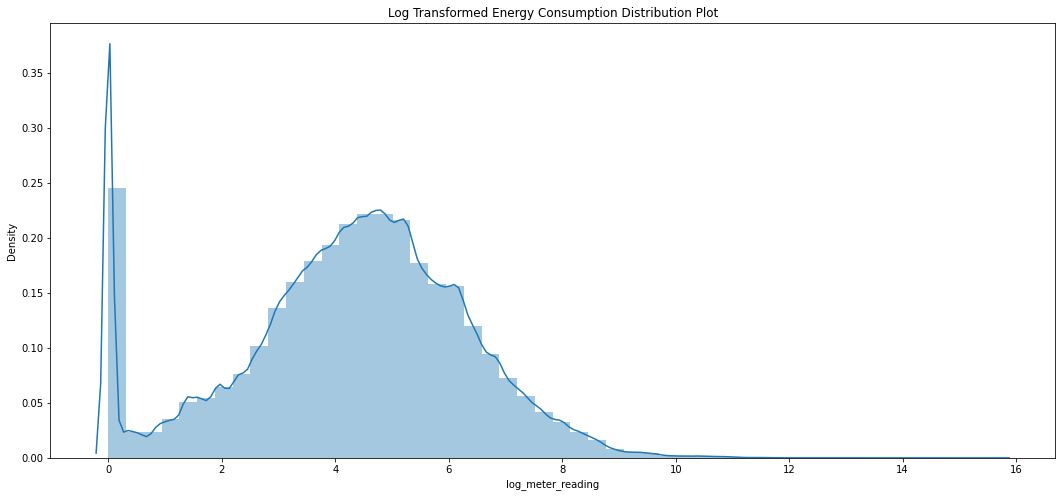

In [367]:
# plot distribution of energy consumption to check if data transformation is required; i.e. logarithmic transformation
plt.figure(figsize=(18,8))
plt.title(f'Log Transformed Energy Consumption Distribution Plot')
sns.distplot(final_train_df['log_meter_reading'])

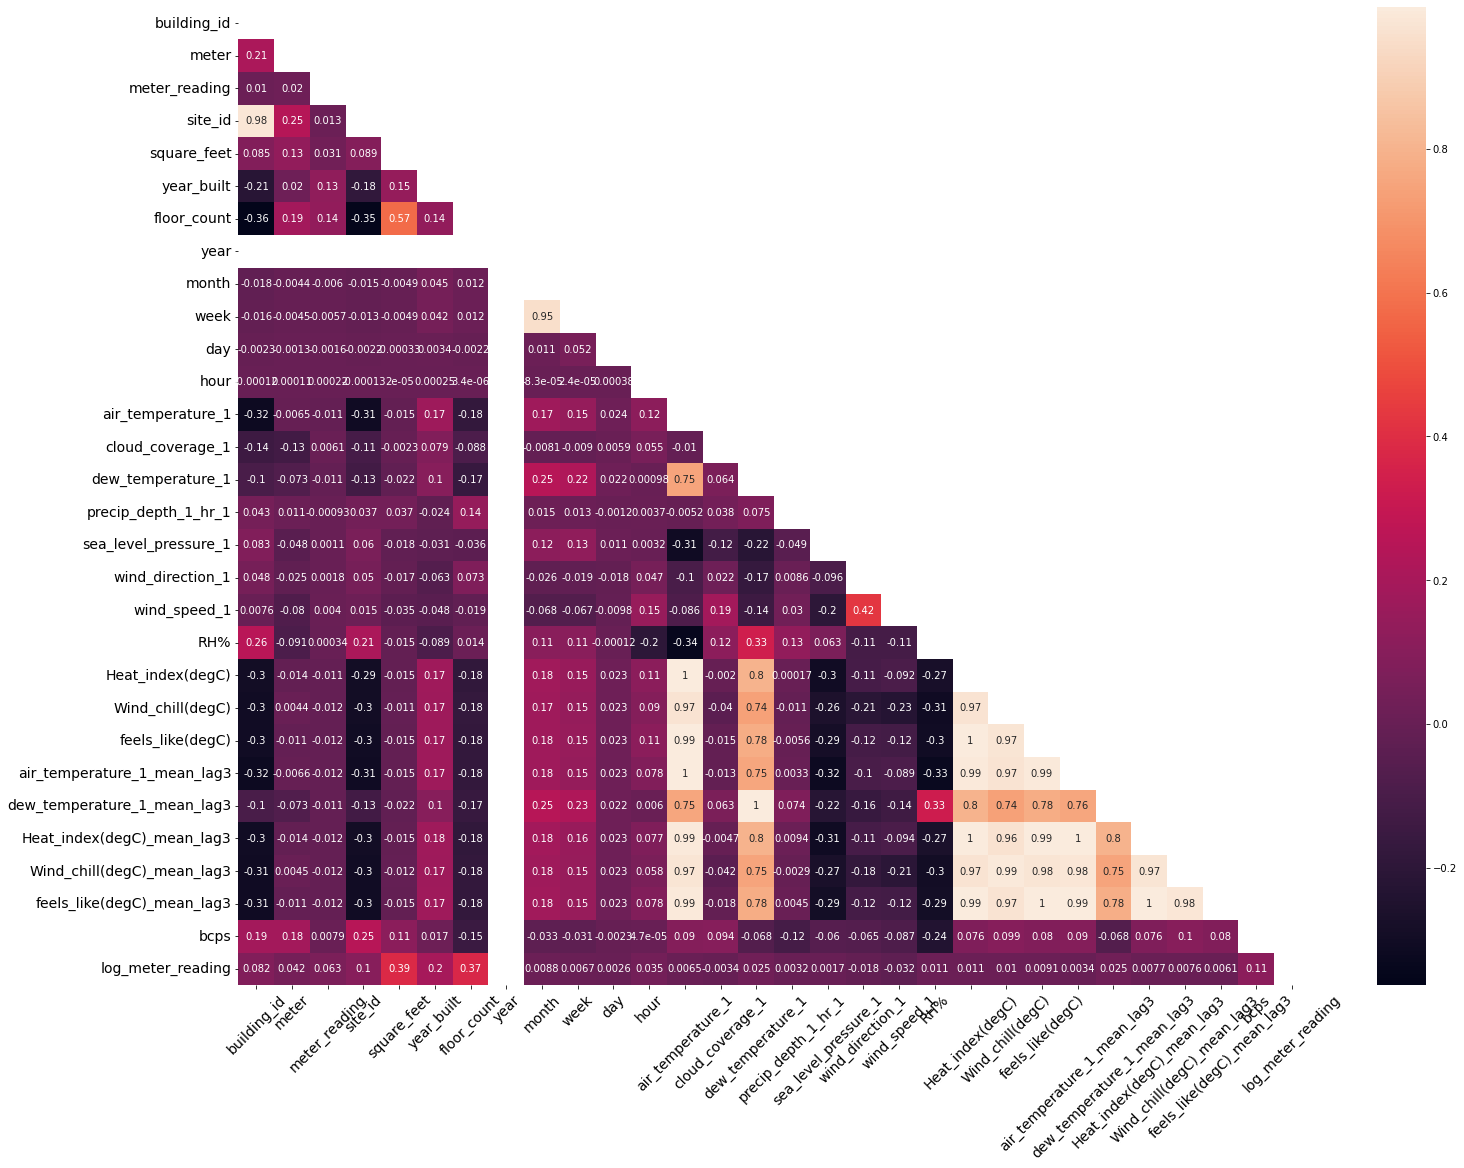

In [368]:
# Generate a mask for the upper triangle (taken from Seaborn example gallery).
mask = np.zeros_like(final_train_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True       

fig, ax = plt.subplots(figsize=(24,18))

# Plot the heat map with Seaborn.
ax = sns.heatmap(final_train_df.corr(), mask=mask, annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

Observation: We can see that log transformed meter reading have a moderate correlation with square feet and year built and floor count. However, both year built and floor count has more than 50% of null values.

In [369]:
#drop year_built and floor_count for our train and test datasets
final_train_df.drop(columns=['year_built','floor_count','year'],inplace=True)
final_test_df.drop(columns=['year_built','floor_count','year'],inplace=True)

In [370]:
final_test_df.columns.difference(final_train_df.columns)

Index(['row_id'], dtype='object')

In [371]:
final_train_df.columns.difference(final_test_df.columns)

Index(['log_meter_reading', 'meter_reading'], dtype='object')

In [372]:
#save merged train and test datasets 
# final_train_df.to_csv('../datasets/cleaned/cleaned_train_df2.csv',index=False)
# final_test_df.to_csv('../datasets/cleaned/cleaned_test_df2.csv',index=False)

final_train_df.to_csv('s3://jiashengs3/cleaned_train3.csv', index=False)
final_test_df.to_csv('s3://jiashengs3/cleaned_test3.csv', index=False)